In [1]:
#enable interactive widgets in a notebook
%matplotlib widget

# Notes

This jupyter notebook contains a tool for theoretically estimating the performance of the MWA's VCSBeam Beamforming pipeline on SRCNet computing resources for SKA-like datasets

# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Slider

# Functions

In [3]:
def wall_time(obs_t_new,n_st_new,obs_t_old=600,n_st_old=128,w_t_old=14):
    """
    Function to estimate the wall time to process a single coarse channel of an SKA-like TBB daraset
    on a GPU using the VCSBeam Beamformer in PSRFITS-out mode.

    Notes:

    This calculation is based on the results of historical VCSBeam profiling tests on the MWA's
    Pawsey supercomputers. Any calculation which uses the wall time from this function is inherently
    making the assumption that the GPUs they are using to process the dataset perform identically
    to Pawesy's AMD MI250X GPU cards.

    Details about this calculation, and all its underlying assumptions, can be found
    on the SKA confluence page. See Equation 8 here: https://confluence.skatelescope.org/x/TqkSEw

    Inputs:

    obs_t_new : [float] the duration in seconds of the SKA-like dataset
    n_st_new  : [int] the number of SKA stations to be processexd
    obs_t_old : [float] the duration in seconds of the MWA dataset used in
                        the original Pawsey profiling test (should be 600)
    n_st_old  : [int] the number of MWA stations which were used in the 
                    original Pawsey profiling test (should be 128)
    w_t_old   : [float] the wall time in minutes that it took to process one channel of 
                        the 1-pointing, 24-channel, 10-minute legacy MWA dataset 
                        with VCSBeam in the original Pawsey profiling tests (should be 14)

    Returns:

    w_t_new   : [float] the estimated time in minutes to process one channel of an SKA-like
                        dataset on Pawsey
    
    """

    w_t_new = w_t_old * (obs_t_new/obs_t_old) * (n_st_new/n_st_old)
    
    return w_t_new

def n_subjobs(n_chans,n_nodes,n_gpus):
    """
    As VCSBeam processes one frequency channel per available GPU card in a cluster,
    it can process multiple channels simultaneously on a node with multiple GPU cards.
    This function calculates the number of subjobs required to process a full SKA-like
    TBB dataset of n_chan channels on a computing system of n_node nodes, each with n_gpu cards.
    One subjob will process one coarse frequency channel per gpu card simultaneously.
    
    Notes:
    
    Details about this calculation, and all its underlying assumptions, can be found
    on the SKA confluence page. See Equation 5 here: https://confluence.skatelescope.org/x/TqkSEw
    
    Inputs:

    n_chans : [int] the number of coarse channels to be processed in the TBB dataset
    n_nodes : [int] the number of nodes available on the computing system
    n_gpus : [int] the number of gpu cards per node

    Returns:

    n_subjobs : [int] the number of subjobs required to process the full dataset.
    
    """

    #calculate the number of subjobs jobs run fully using all GPUs
    n_subjobs = n_chans // (n_nodes*n_gpus)
    #calculate the remaining number of channels that need processing
    remainder = n_chans % (n_nodes*n_gpus)
    #if the remainder > 0, add one more to the number of subjobs needed to process
    #all channels
    if remainder>0:
        n_subjobs+=1
    
    return n_subjobs

def proc_time(w_t_new,n_subjobs):
    """
    Function to calculate the total time required to process an SKA-like TBB dataset of
    certain input parameters (number of channels, number of stations, duration of 
    the observation) using VCSBeam in PSRFITS-out mode on a computing system of n_nodes,
    each with n_gpu gpu cards.

    This function is designed to be used alongside wall_time() and n_subjobs().

    Notes: 

    By using this function, you are assuming that:
    
    - the GPUs used to process the dataset perform identically
    to Pawesy's AMD MI250X GPU cards.
    - VCSBeam wall time scales linearly with observing time
    - the time required to stitch channels within sub-jobs is identical
    - there are no other unanticipated nonlinear effects due to MPI communication overheads
    - there are no unanticipated nonlinear effects due to file I/O times.
    - for a coarse channel, VCSBeam performance scales linearly with stations in the array
    - we are disregarding any time required to stitch the data from different subjobs together
    - We have assumed the SKA data has MWA-like digitisation and channel widths in this calculation.
    
    Details about this calculation, and all its underlying assumptions, can be found
    on the SKA confluence page. See Equation 6 here: https://confluence.skatelescope.org/x/TqkSEw
    
    Inputs:

    w_t_new   : [float] the estimated time in minutes to process one channel of an SKA-like
                        dataset on Pawsey
    n_subjobs : [int] the number of subjobs required to process the full dataset.
    
    Returns:

    P_t : [float] the total time required to process the dataset in minutes.
    """

    #print(w_t_new, n_subjobs)
    #print(w_t_new *n_subjobs)

    P_t = w_t_new * n_subjobs

    return P_t

def gpu_hrs(n_nodes,n_gpus,w_t_new,n_subjobs):
    """
    Function to calculate the total number of GPU hours required to process an SKA-like TBB dataset of
    certain input parameters (number of channels, number of stations, duration of the observation) using
    VCSBeam in PSRFITS-out mode on a computing system of n_nodes nodes, each with n_gpu gpu cards.

    This function is designed to be used alongside wall_time() and n_subplots().

    Notes: 

    By using this function, you are assuming that:
    
    - the GPUs used to process the dataset perform identically
    to Pawesy's AMD MI250X GPU cards.
    - VCSBeam wall time scales linearly with observing time
    - the time required to stitch channels within sub-jobs is identical
    - there are no other unanticipated nonlinear effects due to MPI communication overheads
    - there are no unanticipated nonlinear effects due to file I/O times.
    - for a coarse channel, VCSBeam performance scales linearly with stations in the array
    - we are disregarding any time required to stitch the data from different subjobs together
    - We have assumed the SKA data has MWA-like digitisation and channel widths in this calculation.
    
    Details about this calculation, and all its underlying assumptions, can be found
    on the SKA confluence page. See Equation 3 here: https://confluence.skatelescope.org/x/TqkSEw

    Inputs:

    n_nodes   : [int] the number of nodes available on the computing system
    n_gpus    : [int] the number of gpu cards per node
    w_t_new   : [float] the estimated time in minutes to process one channel of an SKA-like
                        dataset on Pawsey
    n_subjobs : [int] the number of subjobs required to process the full dataset.
    
    Returns:

    cost : [float] the total number of GPU-hours required to process the dataset.
    
    """

    cost = n_nodes*n_gpus*((w_t_new*n_subjobs)/60)
    
    return cost

# The tool

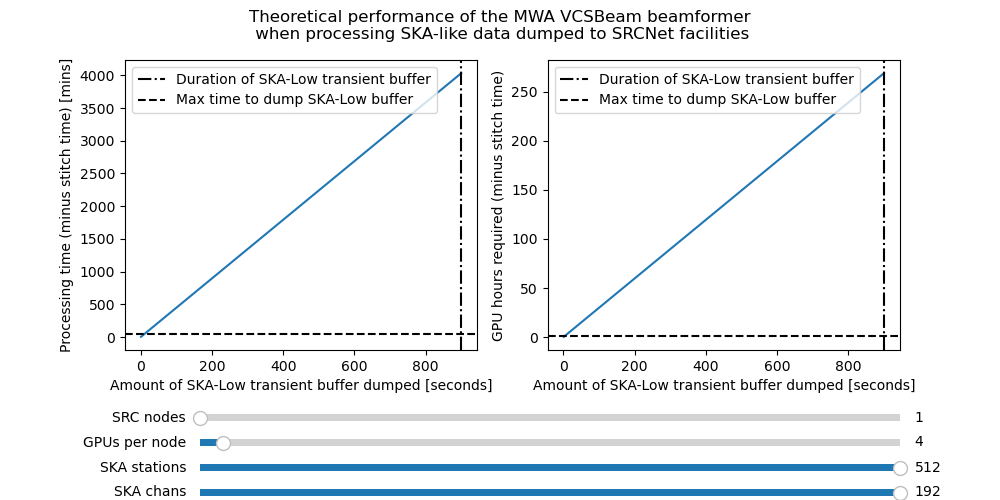

In [4]:
#define a range of SKA TBB event data durations in seconds
obs_t_SKA = np.linspace(1,900,10)

#initial SKA data information for scaling
n_chans_SKA = 192 #initial number of channels in the SKA-like dataset
n_st_SKA = 512 #initial number of stations in the SKA-like dataset

#initial SRCNet computing information for scaling
n_nodes = 1 #initial number of nodes in the SRCNet computing system
n_GPUs = 4 #initial number of GPU cards per node in the SRCNet computing system

#calculate initial number of subjobs
initial_n_subjobs = n_subjobs(n_chans_SKA,n_nodes,n_GPUs)

#calculate initial wall time
initial_wall_time = wall_time(obs_t_SKA,n_st_SKA)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(bottom=0.3)

#calculate the initial range of processing times based on SKA and SRCNet initial parameters
p_t, = ax1.plot(obs_t_SKA, proc_time(wall_time(obs_t_SKA,n_st_SKA),n_subjobs(n_chans_SKA,n_nodes,n_GPUs)))

#calculate the initial range of necessary GPU hours based on SKA and SRCNet initial parameters
gpu_t, = ax2.plot(obs_t_SKA, gpu_hrs(n_nodes,n_GPUs,wall_time(obs_t_SKA,n_st_SKA),n_subjobs(n_chans_SKA,n_nodes,n_GPUs)))

#plot labels
plt.suptitle("Theoretical performance of the MWA VCSBeam beamformer\n when processing SKA-like data dumped to SRCNet facilities")
ax1.set_ylabel("Processing time (minus stitch time) [mins]")
ax1.set_xlabel("Amount of SKA-Low transient buffer dumped [seconds]")
ax2.set_ylabel("GPU hours required (minus stitch time)")
ax2.set_xlabel("Amount of SKA-Low transient buffer dumped [seconds]")

#extra information
ax1.axvline(900,0,4000,ls='-.',color='k',label = 'Duration of SKA-Low transient buffer')
ax1.axhline(45,0,1000,ls='--',color='k',label = 'Max time to dump SKA-Low buffer')
ax2.axvline(900,0,500,ls='-.',color='k',label = 'Duration of SKA-Low transient buffer')
ax2.axhline(45/60,0,1000,ls='--',color='k',label = 'Max time to dump SKA-Low buffer')

# Slider settings
slider_ax_chans = plt.axes([0.2, 0.0, 0.7, 0.03])
slider_ax_stations = plt.axes([0.2, 0.05, 0.7, 0.03])
slider_ax_GPUs = plt.axes([0.2, 0.1, 0.7, 0.03])
slider_ax_nodes = plt.axes([0.2, 0.15, 0.7, 0.03])

slider_chans = Slider(slider_ax_chans, 'SKA chans', 128, 192, valinit=n_chans_SKA,valstep=1)
slider_stations = Slider(slider_ax_stations, 'SKA stations', 128, 512, valinit=n_st_SKA,valstep=1)
slider_GPUs = Slider(slider_ax_GPUs, 'GPUs per node', 2, 64, valinit=n_GPUs,valstep=1)
slider_nodes = Slider(slider_ax_nodes, 'SRC nodes', 1, 15, valinit=n_nodes,valstep=1)

#updating sliders
def update(val):
    chans = slider_chans.val
    stations = slider_stations.val
    GPUs = slider_GPUs.val
    nodes = slider_nodes.val
    
    p_t.set_ydata(proc_time(wall_time(obs_t_SKA,stations),n_subjobs(chans,nodes,GPUs)))
    gpu_t.set_ydata(gpu_hrs(nodes,GPUs,wall_time(obs_t_SKA,stations),n_subjobs(chans,nodes,GPUs)))

    fig.canvas.draw_idle()

slider_chans.on_changed(update)
slider_stations.on_changed(update)
slider_GPUs.on_changed(update)
slider_nodes.on_changed(update)

ax1.legend()
ax2.legend()

plt.show()
